In [2]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu, zscore
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr
from enigmatoolbox.datasets import load_sc, load_fc

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [5]:
data_path = "/Users/abry4213/data/HCP100/"

#### IN-HOUSE DATA FROM FALLON 2020 ####
HCP_in_house_Pearson_FC = pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*_all_pyspi_Pearson_results.csv")])

HCP_avg_in_house_Pearson_FC = (HCP_in_house_Pearson_FC
                               .assign(Brain_Region_From = lambda x: x.hemi_from + "_" + x.base_region_from,
                                       Brain_Region_To = lambda x: x.hemi_to + "_" + x.base_region_to)
                               .groupby(['Brain_Region_From', 'Brain_Region_To'])['value']
                               .mean()
                               .reset_index()
                               .rename(columns={"value": "Mean_Pearson_R"})
                               .assign(Dataset="In-house HCP")
)

#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 
# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation='aparc')


# Read in preprocessed Pearson-based functional connectivity data from ENIGMA
HCP_avg_Pearson_FC = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)
pearson_homotopic_res_mean = (HCP_avg_Pearson_FC
                              .query("Base_Region_From == Base_Region_To")
                              .groupby(["Base_Region_From"])['Mean_Pearson_R']
                              .mean() 
                              .reset_index()
                              .rename(columns={"Base_Region_From": "Base_Region"})
                              )

all_pearson_res_with_HoFC = (HCP_avg_Pearson_FC
 .assign(Connection_Type = lambda x: np.where(x.Base_Region_From == x.Base_Region_To, 'Homotopic', np.where(x.Hemi_From==x.Hemi_To, 'Intra-hemispheric', 'Inter-hemispheric')))
 .groupby(['Base_Region_From', 'Base_Region_To', 'Connection_Type'])['Mean_Pearson_R']
    .mean()
    .reset_index()
)


#### GROUP-AVERAGED STRUCTURAL CONNECTOME FROM ENIGMA #### 
sc_ctx, sc_ctx_labels, _, _ = load_sc(parcellation='aparc')

HCP_avg_Pearson_SC = (pd.DataFrame(sc_ctx, columns=sc_ctx_labels)
                      .assign(Brain_Region_From = sc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Num_Streamlines")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)

SC_homotopic_res_mean = (HCP_avg_Pearson_SC
                            .query("Base_Region_From == Base_Region_To")
                            .groupby(["Base_Region_From"])['Mean_Num_Streamlines']
                            .mean() 
                            .reset_index()
                            .rename(columns={"Base_Region_From": "Base_Region"})
                            .rename(columns={"Mean_Num_Streamlines": "Value"})
                            .assign(Category = "Microstructure", Description = "Log-SC")
                            )

# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")

mean_SC_degree_per_region = (HCP_avg_Pearson_SC
                             .assign(Connection_Type = lambda x: np.where(x.Base_Region_From == x.Base_Region_To, 'Homotopic', np.where(x.Hemi_From==x.Hemi_To, 'Intra-hemispheric', 'Inter-hemispheric')))
                             .groupby(['Base_Region_From', 'Connection_Type'])['Mean_Num_Streamlines']
                             .mean()
                             .reset_index()
)

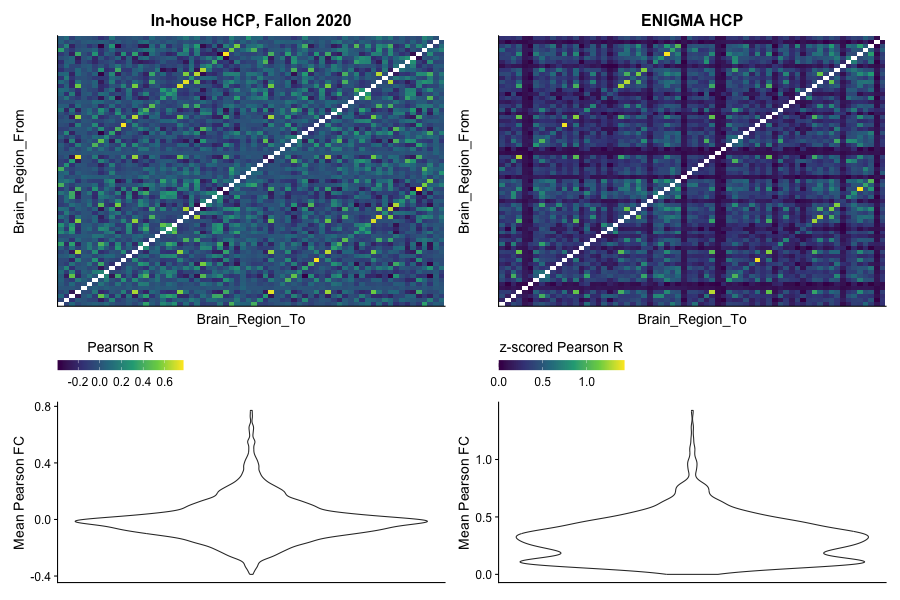

In [6]:
%%R -i HCP_avg_in_house_Pearson_FC,HCP_avg_Pearson_FC -w 900 -h 600

legendwidth <- 1.75

in_house_plot <- HCP_avg_in_house_Pearson_FC %>% 
    filter(Brain_Region_To != Brain_Region_From) %>%
    ggplot(data=., mapping=aes(x=Brain_Region_To, y=Brain_Region_From)) +
    geom_tile(aes(fill=Mean_Pearson_R)) +
    ggtitle("In-house HCP, Fallon 2020") +
    labs(fill="Pearson R") +
    guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
    theme(legend.position='bottom',
        legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
          plot.title = element_text(hjust=0.5, face='bold'),
          axis.text = element_blank(),
          axis.ticks = element_blank()) +
    scale_fill_viridis_c()

ENIGMA_plot <- HCP_avg_Pearson_FC %>%
    filter(Brain_Region_To != Brain_Region_From) %>%
    ggplot(data=., mapping=aes(x=Brain_Region_To, y=Brain_Region_From)) +
    geom_tile(aes(fill=Mean_Pearson_R)) +
    ggtitle("ENIGMA HCP") +
    labs(fill="z-scored Pearson R") +
    guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
    theme(legend.position='bottom',
        legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
          plot.title = element_text(hjust=0.5, face='bold'),
          axis.text = element_blank(),
          axis.ticks = element_blank()) +
    scale_fill_viridis_c()


in_house_violin <- HCP_avg_in_house_Pearson_FC %>% 
    filter(Brain_Region_To != Brain_Region_From) %>%
    ggplot(mapping=aes(x=0, y=Mean_Pearson_R)) +
    ylab("Mean Pearson FC") +
    geom_violin() +
    theme(axis.text.x = element_blank(),
            axis.ticks.x = element_blank(),
            axis.title.x = element_blank()) 

ENIGMA_violin <- HCP_avg_Pearson_FC %>%
    filter(Brain_Region_To != Brain_Region_From) %>%
    ggplot(mapping=aes(x=0, y=Mean_Pearson_R)) +
    ylab("Mean Pearson FC") +
    geom_violin() +
    theme(axis.text.x = element_blank(),
            axis.ticks.x = element_blank(),
            axis.title.x = element_blank())


wrap_plots(list(in_house_plot, ENIGMA_plot, 
                in_house_violin, ENIGMA_violin),
                heights=c(0.6, 0.4), 
           ncol=2, nrow=2) 